# ClimateNet AR/TC Analysis (Extreme Precip)

In [1]:
!pwd

/glade/work/kdagon/ML-extremes/notebooks


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
# Previously: needed cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
# This was resolved in nc-time-axis 1.3.0 (https://github.com/SciTools/nc-time-axis/releases/tag/v1.3.0)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38055 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38055/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38055/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:38373,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38055/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Analysis ideas
- replace `.where` with `.clip` if possible for speed?
- CESM "IVT" output along with AR conditions
- circulation anomalies as in fronts analysis (wait for RCP8.5 masks)

## Set ClimateNet filepath

In [4]:
#cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/" # pretrained LBL model
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model

In [5]:
#cesm_cnet_folders = ["output.cgnet.2000/", "output.cgnet.2001/", "output.cgnet.2002/", "output.cgnet.2003/", "output.cgnet.2004/", "output.cgnet.2005/"] # pretrained LBL model
cesm_cnet_folders = ["results.2000/", "results.2001/", "results.2002/", "results.2003/", "results.2004/", "results.2005/"] # retrained NCAR model

## CESM historical simulation, 2000-2005

In [6]:
#cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc" # pretrained LBL model
cnet_files = "class_masks*.nc" # retrained NCAR model

In [ ]:
# start with year 2000 only to solidfy workflow
#cnet_2000 = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[0]+cnet_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True) # aim for chunk size < 100mb
#cnet_2000

In [7]:
%%time
# read in all the masks, 2000-2005
cnet = [xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cesm_cnet_folders)]
# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 1.85 s, sys: 180 ms, total: 2.03 s
Wall time: 31.6 s


In [8]:
cnet_concat

<xarray.Dataset>
Dimensions:                        (lat: 768, lon: 1152, time: 17520)
Coordinates:
  * time                           (time) object 2000-01-01 03:00:00 ... 2006...
  * lat                            (lat) float64 -90.0 -89.77 ... 89.77 90.0
  * lon                            (lon) float64 0.0 0.3125 ... 359.4 359.7
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [9]:
#cnet_mask = cnet_concat.output_tag # pretrained LBL model
cnet_mask = cnet_concat.__xarray_dataarray_variable__.rename("output_tag") # retrained NCAR model; rename data variable
cnet_mask

<xarray.DataArray 'output_tag' (time: 17520, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(17520, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.9 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    ...                         ...
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             casper19
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 ./b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PSL.20...
    CDO:                        Climate Data Operators version 1.9.9 (https:/...

### Static plot for visualization

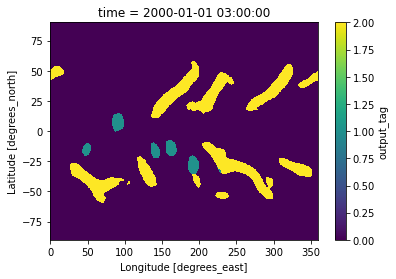

In [168]:
cnet_mask.isel(time=0).plot()

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

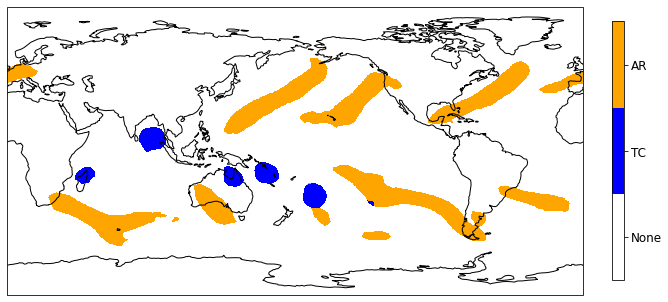

In [169]:
cmap_all = matplotlib.colors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # shift map center to highlight Pacific

lat = cnet_mask.lat
lon = cnet_mask.lon
#cf = ax.contourf(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, levels=bounds, transform=ccrs.PlateCarree())
pc = ax.pcolormesh(lon, lat, cnet_mask.isel(time=0), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) # get rid of edge colors

ax.coastlines()

cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#plt.savefig('../figures/toSCP/climatenet_updateColors_time=0.png', bbox_inches='tight')

### Global AR frequency maps

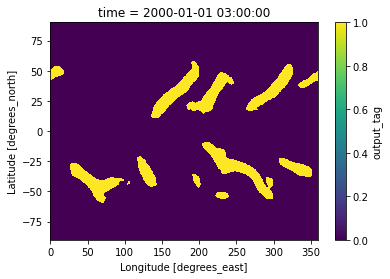

In [188]:
# method to select only ARs (value=2)
# clip is so much faster than where but it doesn't create a masked array
(cnet_mask.clip(min=1).isel(time=0)-1).plot() # in absense of masked array, need to subtract 1 to get ARs = 1 and everything else = 0

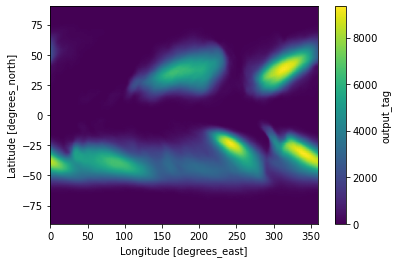

In [189]:
(cnet_mask.clip(min=1)-1).sum(dim='time').plot()

In [185]:
len(cnet_mask.time)

17520

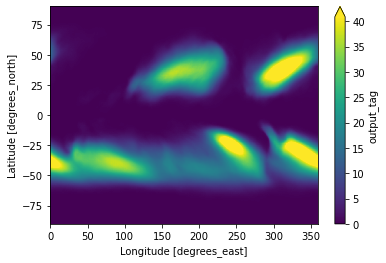

In [191]:
npercentARs = 100*((cnet_mask.clip(min=1)-1).sum(dim='time'))/len(cnet_mask.time)
npercentARs.plot(robust=True)

In [198]:
npercentARs = npercentARs.persist()

In [199]:
npercentARs.max().values

array(53.28196347)

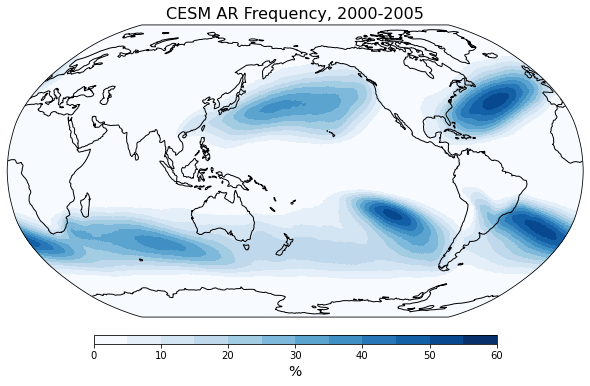

In [206]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=60, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2000-2005', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist.png', bbox_inches='tight')

### Subset AR/TC masks spatially
Helps with analysis and memory usage

Set the spatial domain to use throughout

In [10]:
# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,250)

In [11]:
#cnet_mask_subset = cnet_mask.sel(lat=slice(25,61),lon=slice(189,250)) # Western US domain from AR analysis (e.g., Payne & Magnusdottir (2014,2015) papers, estimated), modified to include land at all lons 
#cnet_mask_subset = cnet_mask.sel(lat=slice(32,50),lon=slice(235,246)) # Restricted western US (mostly land) domain from Collow et al. 2020
cnet_mask_subset = cnet_mask.sel(lat=lat_bounds,lon=lon_bounds)
cnet_mask_subset

<xarray.DataArray 'output_tag' (time: 17520, lat: 170, lon: 225)>
dask.array<getitem, shape=(17520, 170, 225), dtype=int64, chunksize=(50, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.9 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    ...                         ...
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             casper19
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 ./b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PSL.20...
    CDO:                        Climate Data Operators version 1.9.9 (https:/...

### Regional heatmap

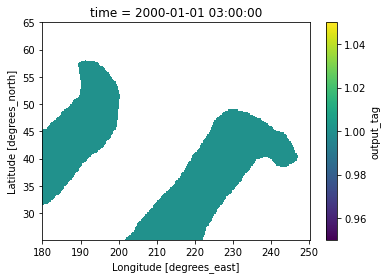

In [17]:
(cnet_mask_subset.where(cnet_mask_subset==2)-1).isel(time=0).plot()

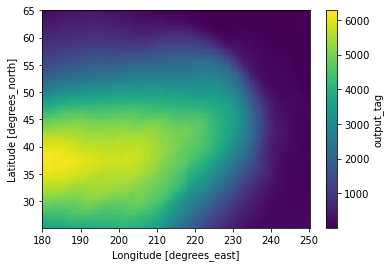

In [18]:
(cnet_mask_subset.where(cnet_mask_subset==2)-1).sum(dim='time').plot()

In [20]:
len(cnet_mask_subset.time)

17520

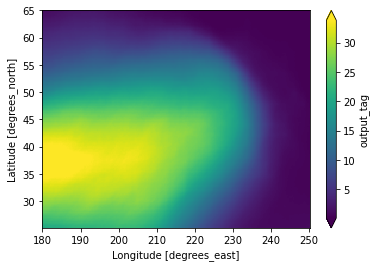

In [21]:
npercentARs_subset = 100*((cnet_mask_subset.where(cnet_mask_subset==2)-1).sum(dim='time'))/len(cnet_mask_subset.time)
npercentARs_subset.plot(robust=True)

In [22]:
npercentARs_subset = npercentARs_subset.persist()

In [23]:
npercentARs_subset.max().values

array(35.78767123)

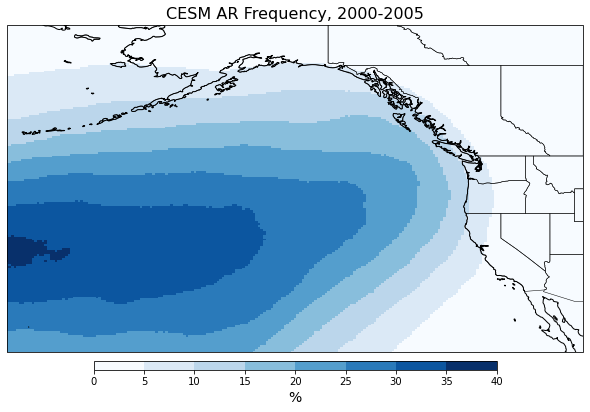

In [57]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues',8)

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs_subset.lat
lon = npercentARs_subset.lon
pc = ax.pcolormesh(lon, lat, npercentARs_subset, cmap=cmap, vmin=0, vmax=40, transform=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.STATES, zorder=2, linewidth=0.5)

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2000-2005', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_ARTMIPregion.png', bbox_inches='tight')

### Seasonal heatmaps

In [43]:
# getting the number of time points in each season (they vary due to month lengths)
season_lengths = cnet_mask_subset.time.groupby('time.season').count()
season_lengths

<xarray.DataArray 'time' (season: 4)>
array([4320, 4416, 4416, 4368])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

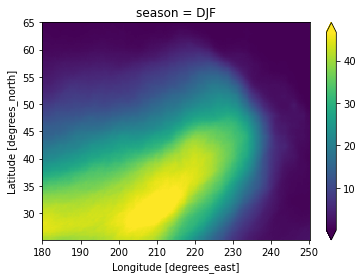

In [46]:
npercentARs_subset_byseason = 100*((cnet_mask_subset.where(cnet_mask_subset==2)-1).groupby('time.season').sum(dim='time'))/season_lengths
npercentARs_subset_byseason.sel(season='DJF').plot(robust=True)

In [47]:
npercentARs_subset_byseason = npercentARs_subset_byseason.persist()

In [48]:
npercentARs_subset_byseason.max().values

array(50.13888889)

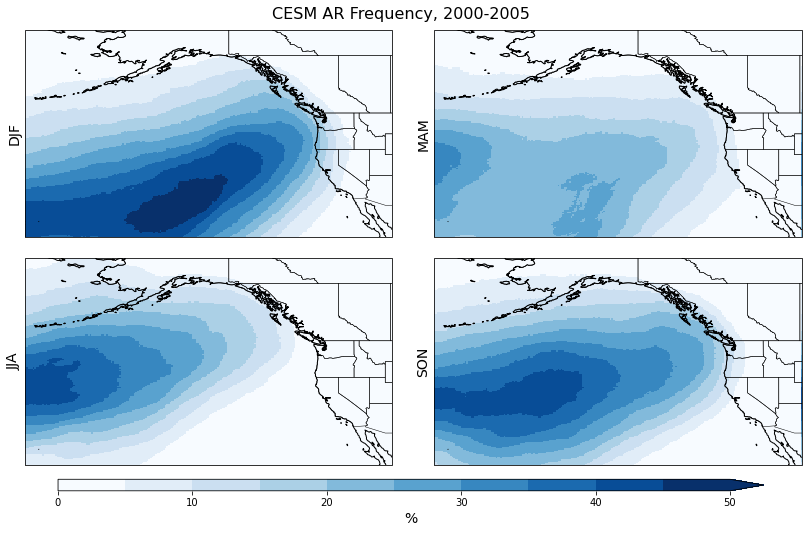

In [55]:
# a nicer plot
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 10) # ARTMIP region

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_subset_byseason.sel(season=season), coord=npercentARs_subset_byseason.lon)
    lat = npercentARs_subset_byseason.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=50, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency, 2000-2005', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_ARTMIPregion_byseason.png', bbox_inches='tight')

### Read in landfrac for this grid

In [58]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)
landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)
#landfrac

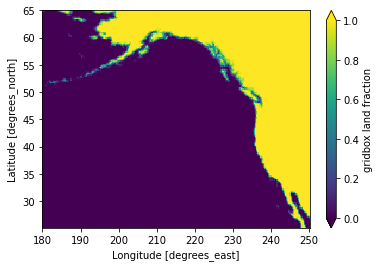

In [39]:
landfrac.plot(robust=True)

## Read in precipitation field

In [59]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output

In [60]:
# h4.PRECT is 3hrly instantaneous
# h3.PRECT is 3hrly average

#PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
#PRECT_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT.2000010100Z-2000123121Z.FV.nc" # testing year 2000 only
PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PRECT*regrid*"

preprocessing function to return PRECT only\
with option to subset spatially (save memory)

In [61]:
def preprocess(ds):
    #return ds['PRECT']
    #return ds['PRECT'].sel(lat=slice(10,77),lon=slice(189,329)) # NA domain from Front analysis
    #return ds['PRECT'].sel(lat=slice(25,61),lon=slice(189,250)) # Western US domain from AR analysis 
    #return ds['PRECT'].sel(lat=slice(32,50),lon=slice(235,246)) # Restricted western US
    return ds['PRECT'].sel(lat=lat_bounds,lon=lon_bounds)

read in PRECT files with preprocessing function (only with multi file)

In [62]:
%%time
PRECT_hist = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':500,'lat':100,'lon':200}, parallel=True, preprocess=preprocess)
#PRECT_hist = xr.open_dataset(cesm_hist_filepath+PRECT_hist_file, chunks={'time':500,'lat':100,'lon':200})

CPU times: user 1.37 s, sys: 66.3 ms, total: 1.44 s
Wall time: 10.4 s


In [44]:
PRECT_hist

<xarray.DataArray 'PRECT' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=float32, chunksize=(500, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

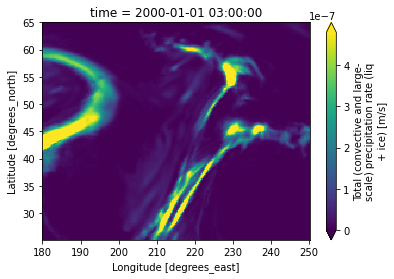

In [45]:
PRECT_hist.isel(time=0).plot(robust=True)

### Process extreme precipitation for a given data array and percentile

In [63]:
def process_PEx(da, landfrac, percentile):
         
    # subset for land only (optional; comment out to use whole domain)
    da = da.where(landfrac > 0)
    
    quantile = percentile/100
    
    # PEx over space
    pX = da.chunk({'time': -1}).quantile(quantile, dim='time')
    PEx = da.where(da > pX)
    
    # PEx over time
    pX_time = da.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    PEx_time = da.where(da > pX_time)
    
    return(PEx, PEx_time)

In [64]:
%%time
percentile=90
PEx, PEx_time = process_PEx(PRECT_hist, landfrac, percentile)

CPU times: user 63 ms, sys: 555 µs, total: 63.5 ms
Wall time: 65.4 ms


In [65]:
PEx

<xarray.DataArray 'PRECT' (time: 17520, lat: 170, lon: 225)>
dask.array<where, shape=(17520, 170, 225), dtype=float32, chunksize=(500, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon       (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

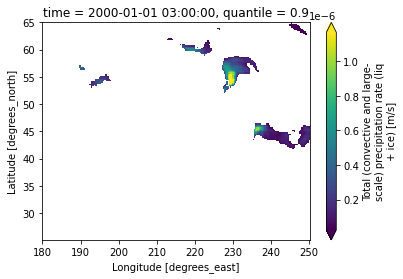

In [50]:
# note this is land only
PEx.isel(time=0).plot(robust=True)

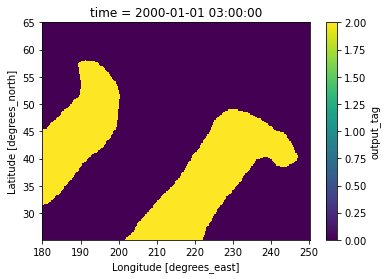

In [51]:
# ARs/TCs at the same time index
cnet_mask_subset.isel(time=0).plot();

## Calculate percent gridpoints that overlap, also return PEx gridpoints
Note for processing global files: Running out of memory for these steps (even with just year 2000). Possible solutions could include launching jupyter on compute node for >4GB memory and/or modify client memory and workflow to reduce data sizes. Or running over a specific spatial region.

In [66]:
def calc_overlap_space(cnet,PEx):

    # start with ARs only
    PEx_AR = PEx.where(cnet==2)
    #PEx_TC = PEx.where(cnet==1)
    
    # sum PEx gridpoints over space
    PExgridpoints = PEx.notnull().sum(dim=('lat','lon'))
    
    # overlap summed over space
    overlap = PEx_AR.notnull().sum(dim=('lat','lon'))

    # percent overlap
    npercentPEx = 100*(overlap/PExgridpoints)
    
    return(PEx_AR, npercentPEx, PExgridpoints)

In [67]:
PEx_AR, npercentPEx_space, PExgridpoints_space = calc_overlap_space(cnet_mask_subset, PEx)

In [68]:
PEx_AR # note this is PEx based over space

<xarray.DataArray 'PRECT' (time: 17520, lat: 170, lon: 225)>
dask.array<where, shape=(17520, 170, 225), dtype=float32, chunksize=(50, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon       (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

In [69]:
def calc_overlap_time(cnet,PEx):
    
    # start with ARs only
    PEx_AR = PEx.where(cnet==2)
    #PEx_TC = PEx.where(cnet==1)
    
    # sum PEx gridpoints over time
    PExgridpoints = PEx.notnull().sum(dim='time')
    
    # overlap summed over time
    overlap = PEx_AR.notnull().sum(dim='time')

    # percent overlap
    npercentPEx = 100*(overlap/PExgridpoints)
    
    # repeat by season
    PExgridpoints_byseason = PEx.notnull().groupby("time.season").sum(dim='time') # by season (4; DJF, JJA, MAM, SON)
    overlap_byseason = PEx_AR.notnull().groupby("time.season").sum(dim='time')
    npercentPEx_byseason = 100*(overlap_byseason/PExgridpoints_byseason)
    
    return(PEx_AR, npercentPEx, npercentPEx_byseason, PExgridpoints, PExgridpoints_byseason)

In [70]:
PEx_AR_time, npercentPEx_time, npercentPEx_time_byseason, PExgridpoints_time, PExgridpoints_time_byseason = calc_overlap_time(cnet_mask_subset, PEx_time)

In [71]:
PEx_AR_time # note this is PEx based over time

<xarray.DataArray 'PRECT' (time: 17520, lat: 170, lon: 225)>
dask.array<where, shape=(17520, 170, 225), dtype=float32, chunksize=(50, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon       (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

### Custom precip colormap from unidata
https://unidata.github.io/python-gallery/examples/Precipitation_Map.html \
Can skip this section if need be - just for making illustrative process plots

In [72]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap_prec = mcolors.ListedColormap(cmap_data, 'precipitation')
norm_prec = mcolors.BoundaryNorm(clevs, cmap_prec.N)

In [60]:
# testing time indexing
t = '2000-08-21T21'
PRECT_hist.sel(time=t)[0]

<xarray.DataArray 'PRECT' (lat: 170, lon: 225)>
dask.array<getitem, shape=(170, 225), dtype=float32, chunksize=(100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
    time     object 2000-08-21 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

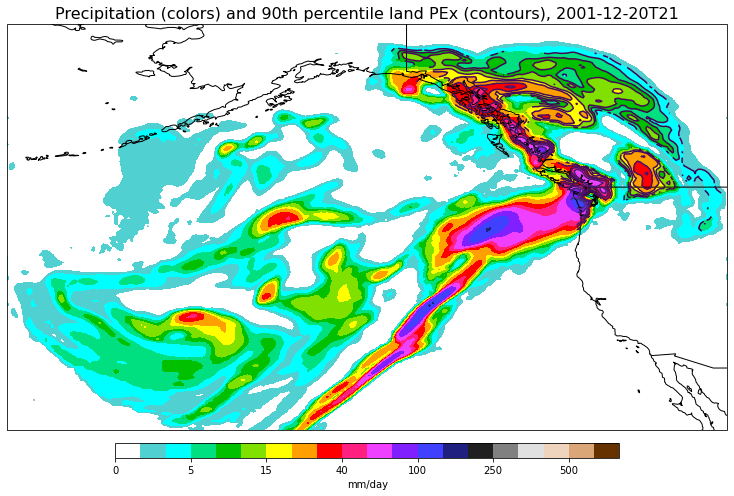

In [73]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

# PEx contours first (land only)
pfield = PEx.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_PEx = ax.contour(lon, lat, field, clevs, transform=ccrs.PlateCarree())

# PRECT filled contour second (land & ocean)
pfield = PRECT_hist.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
#c_prec = ax.pcolormesh(lon, lat, field, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Precipitation (colors) and 90th percentile land PEx (contours), '+t, fontsize=16);
#ax.set_title('90th percentile precipitation, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_CESM_2001-12-20-21.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx_CESM_2001-12-20-21.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_PEx90_CESM_2001-12-20-21.png', bbox_inches='tight')

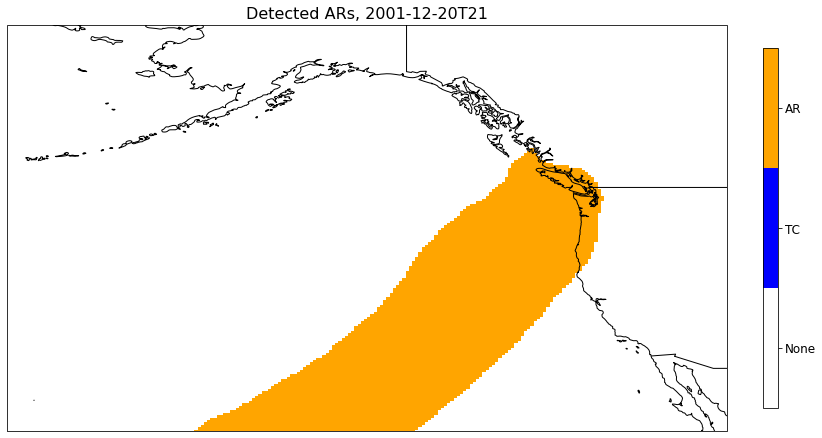

In [75]:
# ARs at the same time index
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

ffield = cnet_mask_subset.sel(time=t)[0]
field, lon = add_cyclic_point(ffield, coord=ffield.lon)
lat = ffield.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# colorbar
cbar_ax = fig.add_axes([1.05, 0.25, 0.02, 0.5])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# add title
ax.set_title('Detected ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/ARs_CESM_2001-12-20-21.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

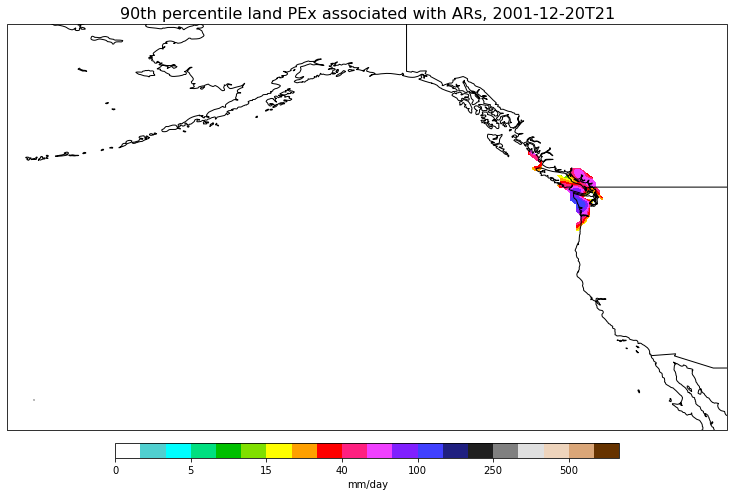

In [76]:
# PEx_AR at the same time index - note land only PEx points and PEx based over space
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# select time index
t = '2001-12-20T21'

pfield = PEx_AR.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# extending the spatial range to force the map to plot more (where there is no PEx_AR)
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('90th percentile land PEx associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx90_AR_CESM_2001-12-20-21.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

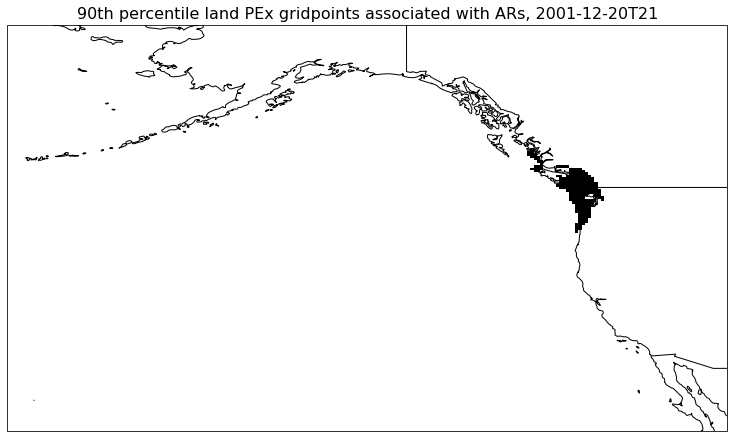

In [77]:
# gridpoints only (no precip info)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

pfield = (PEx_AR.sel(time=t)[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Greys', transform=ccrs.PlateCarree())

ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add title
ax.set_title('90th percentile land PEx gridpoints associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx90_AR_binary_CESM_2001-12-20-21.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

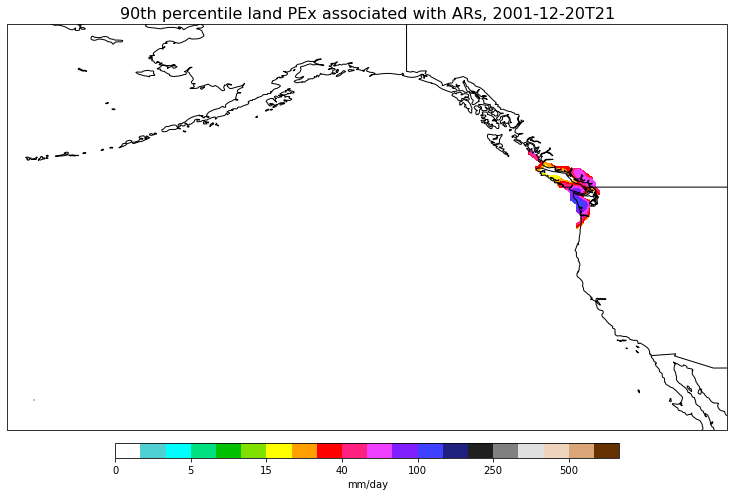

In [78]:
# PEx_AR at the same time index - note land only PEx points and PEx based over time
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# select time index
t = '2001-12-20T21'

pfield = PEx_AR_time.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# extending the spatial range to force the map to plot more (where there is no PEx_AR)
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('90th percentile land PEx associated with ARs, '+t, fontsize=16);

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

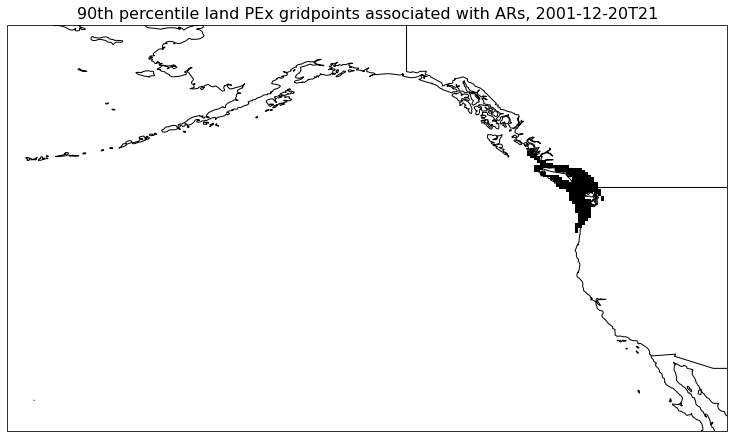

In [79]:
# gridpoints only (no precip info)
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

pfield = (PEx_AR_time.sel(time=t)[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Greys', transform=ccrs.PlateCarree())

ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add title
ax.set_title('90th percentile land PEx gridpoints associated with ARs, '+t, fontsize=16);

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

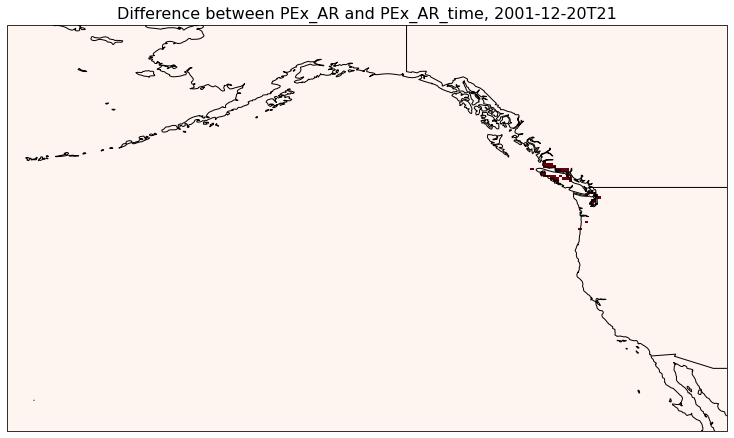

In [80]:
# difference between PEx_AR and PEx_AR_time gridpoints: minimal but they do exist
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

pfield = (PEx_AR_time.sel(time=t)[0]*1000*86400).notnull() != (PEx_AR.sel(time=t)[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Reds', transform=ccrs.PlateCarree())

ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add title
ax.set_title('Difference between PEx_AR and PEx_AR_time, '+t, fontsize=16);

## Visualizing percent PEx

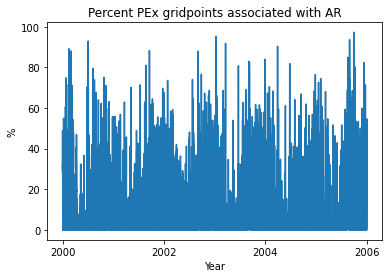

In [81]:
plt.plot(npercentPEx_space.time, npercentPEx_space)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with AR');
#plt.savefig('../figures/toSCP/npercentPEx-AR_2000-2005_3ha.png', bbox_inches='tight')

In [82]:
# mean by month of year
npercentPEx_monthofyear = npercentPEx_space.groupby("time.month").mean().persist()
# standard deviation
npercentPEx_monthofyear_std = npercentPEx_space.groupby("time.month").std().persist()

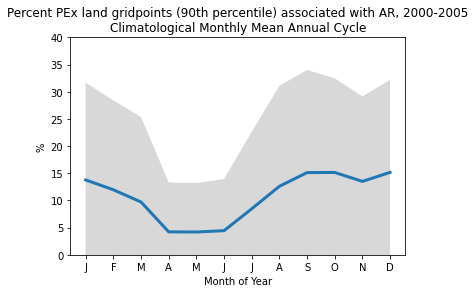

In [83]:
# with fill for standard deviation
plt.plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
#plt.ylim([0,50]) # Payne region, land only
plt.ylim([0,40]) # ARTMIP region, land only
#plt.title('Percent PEx gridpoints associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');
plt.title('Percent PEx land gridpoints (90th percentile) associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');
#plt.savefig('../figures/toSCP/npercentPEx-AR_monthofyear_withstdev_2000-2005_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_monthofyear_withstdev_2000-2005_3ha_payne_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_monthofyear_withstdev_2000-2005_3ha_artmip_landonly.png', bbox_inches='tight')

In [84]:
# mean by time of day
npercentPEx_timeofday = npercentPEx_space.groupby("time.hour").mean().persist()
# standard deviation
npercentPEx_timeofday_std = npercentPEx_space.groupby("time.hour").std().persist()

In [124]:
# 3hrly frequency
npercentPEx_timeofday.hour

<xarray.DataArray 'hour' (hour: 8)>
array([ 0,  3,  6,  9, 12, 15, 18, 21])
Coordinates:
    quantile  float64 0.9
  * hour      (hour) int64 0 3 6 9 12 15 18 21

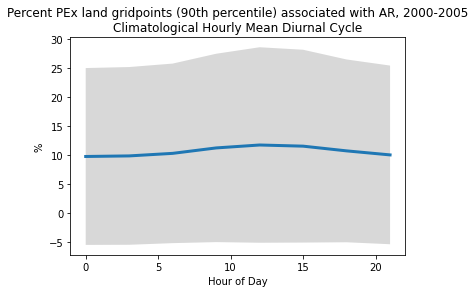

In [88]:
plt.plot(npercentPEx_timeofday.hour, npercentPEx_timeofday, linewidth=3)
plt.fill_between(npercentPEx_timeofday.hour, npercentPEx_timeofday-npercentPEx_timeofday_std, 
                npercentPEx_timeofday+npercentPEx_timeofday_std, alpha=0.3, facecolor='grey')
plt.xlabel('Hour of Day')
plt.ylabel('%')
#plt.ylim([0,30]) # withstdev
plt.title('Percent PEx land gridpoints (90th percentile) associated with AR, 2000-2005\nClimatological Hourly Mean Diurnal Cycle');
#plt.savefig('../figures/toSCP/npercentPEx-AR_timeofday_withstdev_2000-2005_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx-AR_timeofday_2000-2005_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_timeofday_withstdev_2000-2005_3ha_artmip_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_timeofday_2000-2005_3ha_artmip_landonly.png', bbox_inches='tight')

In [89]:
# persist for plotting
npercentPEx_time = npercentPEx_time.persist()

In [90]:
# needed to determine number of values in discrete colormap
npercentPEx_time.max().values

array(48.45360825)

CPU times: user 73.6 ms, sys: 8.22 ms, total: 81.8 ms
Wall time: 128 ms


Text(0.5, 1.0, 'Percent PEx land gridpoints (90th percentile) associated with AR, 2000-2005')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

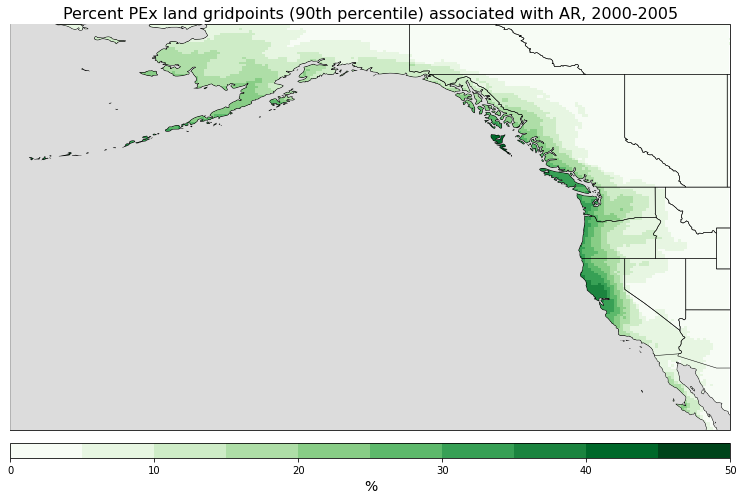

In [91]:
%%time
fig = plt.figure(figsize=(10,10)) # Payne region
#fig = plt.figure(figsize=(7,10)) # Collow region

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# discrete colormap
#cmap=plt.cm.get_cmap('Greens', 14) # Payne region, p90, land/ocean
cmap=plt.cm.get_cmap('Greens', 10) # Collow region, p95, land/ocean; Payne region, p90, land only

field, lon = add_cyclic_point(npercentPEx_time, coord=npercentPEx_time.lon)
lat = npercentPEx_time.lat
#cf = ax.contourf(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())
#cf = ax.pcolor(lon, lat, field, vmin=0, vmax=70, cmap=cmap, transform=ccrs.PlateCarree()) # Payne region, p90, land/ocean
cf = ax.pcolormesh(lon, lat, field, vmin=0, vmax=50, cmap=cmap, transform=ccrs.PlateCarree()) # Collow region, p95, land/ocean; Payne/ARTMIP regions, p90, land only

ax.coastlines(zorder=1)
#ax.add_feature(cfeature.BORDERS, zorder=2) # this is repetative when plotting states
ax.add_feature(cfeature.STATES, zorder=3, linewidth=0.5)

# add greyed out ocean, also helps cut off gridpoints at coastlines
ax.add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0, 0.18, 1, 0.02]) # Payne region
#cb_ax = fig.add_axes([0, -0.05, 1, 0.02]) # Collow region
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('Percent PEx gridpoints associated with AR, 2000-2005', fontsize=16); 
ax.set_title('Percent PEx land gridpoints (90th percentile) associated with AR, 2000-2005', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx-AR_time_2000-2005_3ha.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95th-AR_time_2000-2005_3ha_Collow.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_time_2000-2005_3ha_payne_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_time_2000-2005_3ha_artmip_landonly.png', bbox_inches='tight')

### Seasonal spatial plots

In [92]:
# persist for plotting
npercentPEx_time_byseason = npercentPEx_time_byseason.persist()

In [93]:
# check max for colorbar
npercentPEx_time_byseason.max().values

array(70.66666667)

CPU times: user 242 ms, sys: 10.1 ms, total: 252 ms
Wall time: 342 ms


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

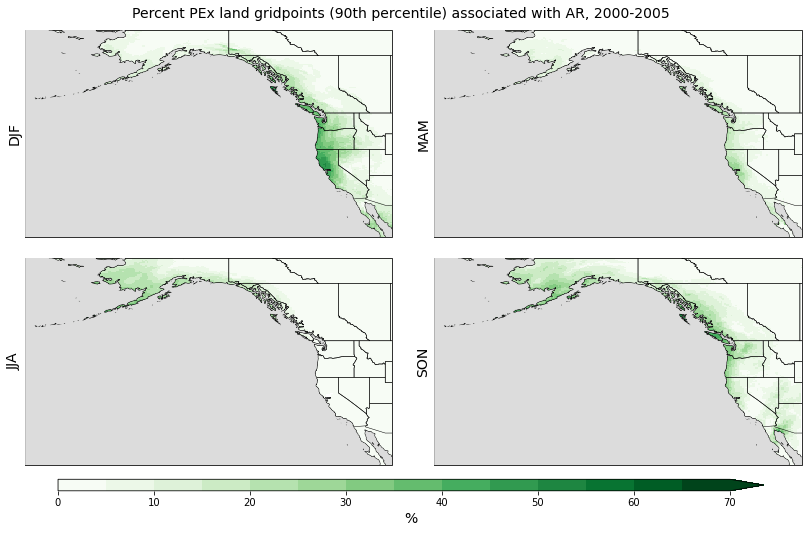

In [94]:
%%time
#fig, axs = plt.subplots(2, 2, figsize=(7,10), subplot_kw={'projection': ccrs.PlateCarree()}) # Collow region
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # Payne region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 14) # Collow region, p95, land/ocean; Payne region, p90, land only
#cmap=plt.cm.get_cmap('viridis', 14) # trying to replicate Collow Fig 1c colorbar

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentPEx_time_byseason.sel(season=season), coord=npercentPEx_time_byseason.lon)
    lat = npercentPEx_time_byseason.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=70, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    #axs[i].add_feature(cfeature.BORDERS, zorder=2)
    axs[i].add_feature(cfeature.STATES, zorder=3, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#fig.suptitle('Percent PEx gridpoints associated with AR, 2000-2005', fontsize=14, y=0.92)
fig.suptitle('Percent PEx land gridpoints (90th percentile) associated with AR, 2000-2005', fontsize=14, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx95th-AR_time_2000-2005_3ha_Collow_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_time_2000-2005_3ha_payne_landonly_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90-AR_time_2000-2005_3ha_artmip_landonly_byseason.png', bbox_inches='tight')

### Close cluster/client as needed

In [95]:
client.close()
cluster.close()